# Importing Library and Reading Data 

In [1]:
import pandas as pd
import numpy as np

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [16]:
df=pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])
df.head(1)

,Survived,Age,Fare
0,0,22.0,7.25


In [22]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [27]:
mean_age = df['Age'].mean()
df['Age'].fillna(mean_age, inplace=True)

In [28]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [30]:
df.shape

(891, 3)

In [31]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


# Train Test Spliting

In [32]:
x=df.iloc[:,1:]
y=df.iloc[:,0]

In [33]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [34]:
x_train.head()

,Age,Fare
331,45.5,28.5000
733,23.0,13.0000
382,32.0,7.9250
704,26.0,7.8542
813,6.0,31.2750


# Without binning

## Creating Model

In [35]:
clf=DecisionTreeClassifier()

In [36]:
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)

In [37]:
accuracy_score(y_test,y_pred)

0.6871508379888268

In [75]:
cvs=np.mean(cross_val_score(DecisionTreeClassifier(),x,y,cv=15,scoring='accuracy'))
cvs

0.6587947269303202

# Using Binning

In [41]:
kbin_age=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [42]:
trns=ColumnTransformer([
    ('age',kbin_age,[0]),
    ('fare',kbin_fare,[1])
])

In [43]:
x_train_trns=trns.fit_transform(x_train)
x_test_trns=trns.transform(x_test)

c:\Users\shubh\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [53]:
trns.named_transformers_['age'].bin_edges_[0].tolist()

[0.42,
 8.399999999999999,
 18.0,
 21.0,
 23.0,
 25.0,
 28.0,
 29.69911764705882,
 31.0,
 34.0,
 38.0,
 44.0,
 51.0,
 80.0]

In [71]:
trns.named_transformers_['fare'].bin_edges_[0].tolist()

[0.0,
 7.2292,
 7.75,
 7.8542,
 7.925,
 8.6625,
 10.5,
 13.0,
 15.677800000000003,
 21.6792,
 26.0,
 30.0,
 39.6875,
 62.438900000000054,
 90.0,
 512.3292]

In [48]:
output = pd.DataFrame({
    'age':x_train['Age'],
    'age_trf':x_train_trns[:,0],
    'fare':x_train['Fare'],
    'fare_trf':x_train_trns[:,1]
})

In [49]:
output.head()

,age,age_trf,fare,fare_trf
331,45.5,11.0,28.5000,10.0
733,23.0,4.0,13.0000,7.0
382,32.0,8.0,7.9250,4.0
704,26.0,5.0,7.8542,2.0
813,6.0,0.0,31.2750,11.0


In [52]:
output['age_label']=pd.cut(x=x_train['Age'],bins=trns.named_transformers_['age'].bin_edges_[0].tolist())

In [54]:
output['fare_label']=pd.cut(x=x_train['Fare'],bins=trns.named_transformers_['fare'].bin_edges_[0].tolist())

In [55]:
output.head()

,age,age_trf,fare,fare_trf,age_label,fare_label
331,45.5,11.0,28.5000,10.0,"(44.0, 51.0]","(26.0, 29.355]"
733,23.0,4.0,13.0000,7.0,"(21.0, 23.0]","(10.5, 13.0]"
382,32.0,8.0,7.9250,4.0,"(31.0, 34.0]","(7.889, 7.925]"
704,26.0,5.0,7.8542,2.0,"(25.0, 28.0]","(7.75, 7.889]"
813,6.0,0.0,31.2750,11.0,"(0.42, 8.4]","(29.355, 39.688]"


In [60]:
clf=DecisionTreeClassifier()
clf.fit(x_train_trns,y_train)

y_pred1=clf.predict(x_test_trns)

In [61]:
accuracy_score(y_test,y_pred1)

0.6312849162011173

In [76]:
x_trns=trns.fit_transform(x)

cvs1=np.mean(cross_val_score(DecisionTreeClassifier(),x_trns,y,cv=15,scoring='accuracy'))
cvs1

c:\Users\shubh\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


0.6645009416195858

In [77]:
print("Accuracy growth: ",cvs1-cvs)

Accuracy growth:  0.005706214689265687


# Creating a Function

In [64]:

def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
        ('age',kbin_age,[0]),
        ('fare',kbin_fare,[1])
    ])
    
    x_trf = trf.fit_transform(x)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),x_trf,y,cv=10,scoring='accuracy')))

    plt.figure(figsize=(14,4))

    plt.subplot(121)
    sns.histplot(x['Age'])
    plt.title('Before')

    plt.subplot(122)
    sns.histplot(x_trf[:,0],color='red')
    plt.title("After")

    plt.show()

    plt.figure(figsize=(14,4))

    plt.subplot(121)
    sns.histplot(x['Fare'])
    plt.title('Before')

    plt.subplot(122)
    sns.histplot(x_trf[:,1],color='red')
    plt.title("After")

    plt.show()

0.6734956304619226


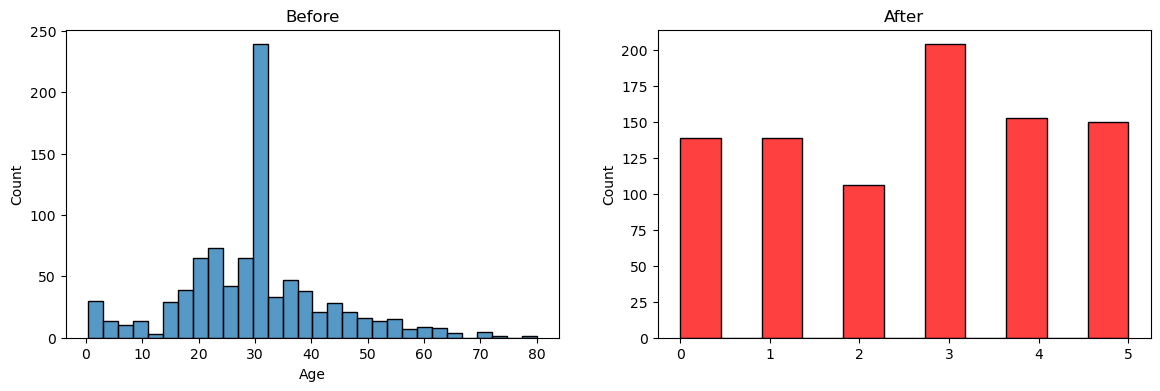

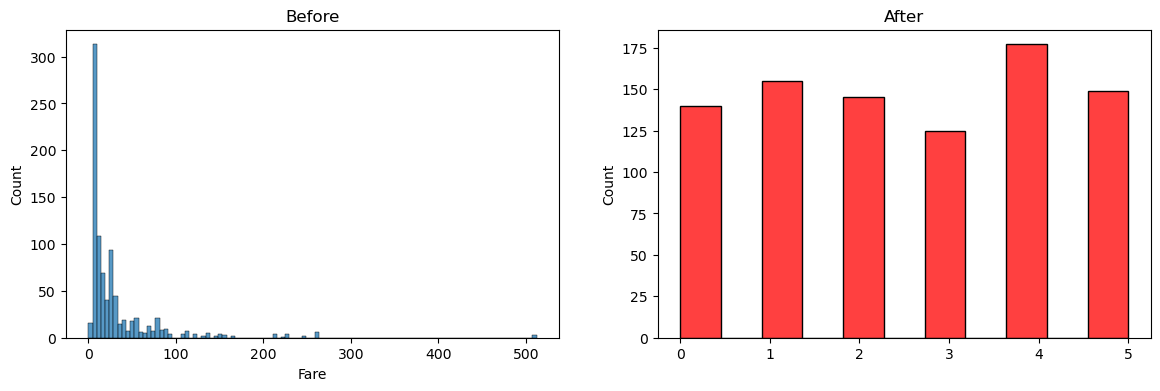

In [67]:
discretize(6,'quantile')